## Problem Definition

Spanish Translation A/B Test

Goal:
1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results
can be trusted.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import os
sns.set_style("white")
os.getcwd()
from scipy.stats import ttest_ind


## Load and clean the data

In [2]:
df_test = pd.read_csv('./Translation_Test/test_table.csv')
df_user = pd.read_csv('./Translation_Test/user_table.csv')

In [3]:
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
df_test.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
user_id             453321 non-null int64
date                453321 non-null object
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [5]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in df_test.columns:
    uniques = df_test[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:10])
    

Variable     count of unique value    content
user_id              453321	 [315281 497851 848402 290051 548435 540675 863394 527287 261625  10427]
date                    5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source                  3	 ['Direct' 'Ads' 'SEO']
device                  2	 ['Web' 'Mobile']
browser_language        3	 ['ES' 'Other' 'EN']
ads_channel             6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser                 7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
conversion              2	 [1 0]
test                    2	 [0 1]


In [6]:
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in df_user.columns:
    uniques = df_user[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])
    

Variable     count of unique value    content
user_id              452867	 [765821 343561 118744 987753 554597  62371 987967]
sex                     2	 ['M' 'F']
age                    52	 [20 27 23 29 31 21 49]
country                17	 ['Mexico' 'Nicaragua' 'Colombia' 'Venezuela' 'Spain' 'Ecuador' 'Paraguay']


Check two tables if there exists repeated users.

In [8]:
# Check uniqueness
#print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('Test table Unique User Ids:\t', len(df_test['user_id'].unique()),'\t',
      len(df_test['user_id'].unique())==len(df_test['user_id']) )
print('User table Unique User Ids:\t', len(df_user['user_id'].unique()),'\t',
      len(df_user['user_id'].unique())==len(df_user['user_id']) )

Test table Unique User Ids:	 453321 	 True
User table Unique User Ids:	 452867 	 True


It is clear that two tables do not have repeated users and for some users in the test set, we miss their information about sex, age and country. Thus, when joining, we have to guarantee the compeleteness of user ids in the test table. I am planning to let user table to left join test table.

## Q1. Confirm that the test is actually negative

In [9]:
# Merge two tables and use left join
data=pd.merge(df_test,df_user,how='left',on='user_id')

Before we confrim that the old version of the site with just one translation across Spain and LatAm performs better, we should check that if it is true that conversion is high in Spain.

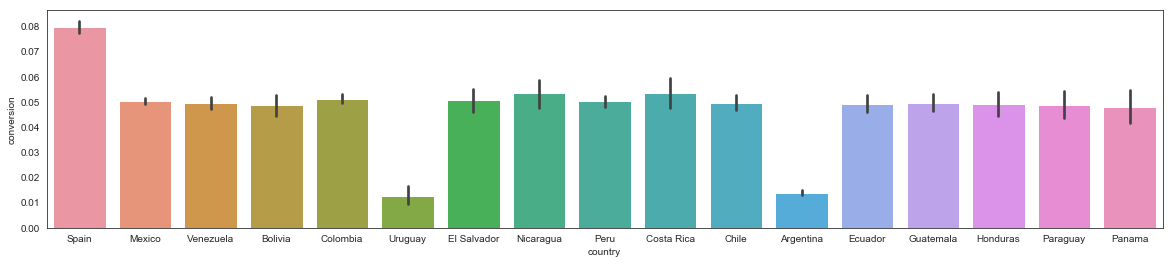

In [10]:
fig,ax=plt.subplots(1,1,figsize=(20,4))
sns.barplot(x=data['country'],y=data['conversion']);

Obviously, Spain does have the highest mean conversion rate among all countries. Now I am trying to confirm that the test is negative by using t test.

In [11]:
# Determine dataset
data_goal = data[data['country']!='Spain'] # We will not include users based in Spain because nothing changed here.
Cont=data_goal[data_goal['test']==0]
Test=data_goal[data_goal['test']==1]

In [12]:
print(ttest_ind(Test['conversion'].values, Cont['conversion'].values, equal_var=False))
print('Mean of control group:','\t',Cont['conversion'].values.mean())
print('Mean of test group:', '\t', Test['conversion'].values.mean())

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)
Mean of control group: 	 0.04833042316066309
Mean of test group: 	 0.043424713982118966


We can see that control group without changing translation has a converting at 4.8%, however, users in test group with localized translation just convert at 4.3%. It does have a negative effect for changing translation.

## Q2. Explain why that might be happening. Are the localized translations really worse?

In order to answer this question, I will first visualize multiple variables by breaking data into control and test group to give me some insights.

In [13]:
def visualization(data1,data2,nrows,ncols):
    columns = data.select_dtypes(include=['object']).columns[1:7]
    print('-' * 32,'Meansure each variable performance on control and test group','-' * 32)
    print(' ' * 100)
    for column in columns:
        # Source variable visualization on control and test group
        fig, ax = plt.subplots(nrows,ncols,figsize=(18,6))
        sns.countplot(data1[column],ax=ax[0,0],order=sorted(data1[column].value_counts().index))
        sns.countplot(x=data1[column],hue=data1['conversion'],ax=ax[0,1],order=sorted(data1[column].value_counts().index))
        sns.barplot(data1['conversion'],data1[column],ax=ax[0,2],order=sorted(data1[column].value_counts().index))
        sns.countplot(data2[column],ax=ax[1,0],order=sorted(data2[column].value_counts().index))
        sns.countplot(x=data2[column],hue=data2['conversion'],ax=ax[1,1],order=sorted(data2[column].value_counts().index))
        sns.barplot(data2['conversion'],data2[column],ax=ax[1,2],order=sorted(data2[column].value_counts().index))
        fig.subplots_adjust(top=0.2)
        fig.suptitle('Control vs Test',fontsize=14)
        plt.tight_layout()

-------------------------------- Meansure each variable performance on control and test group --------------------------------
                                                                                                    


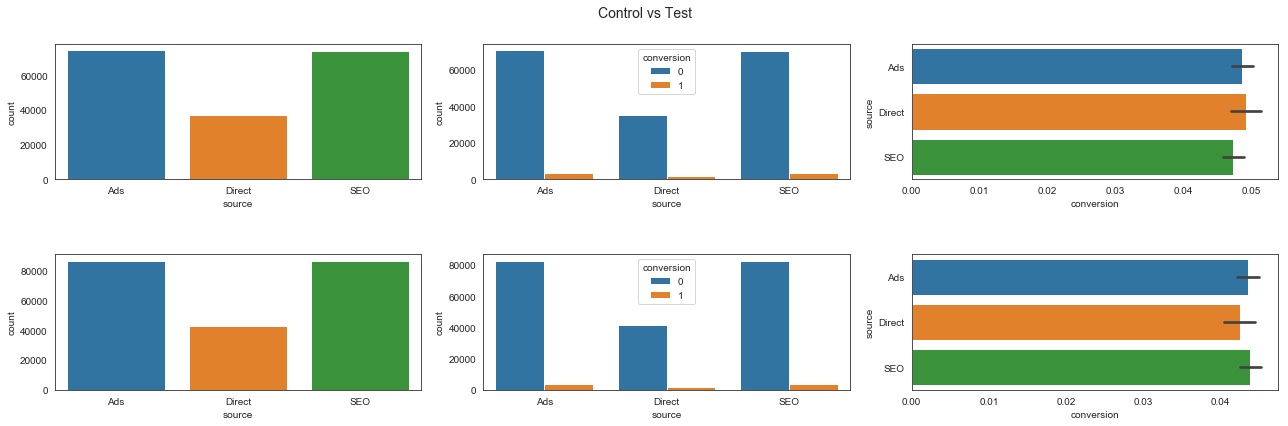

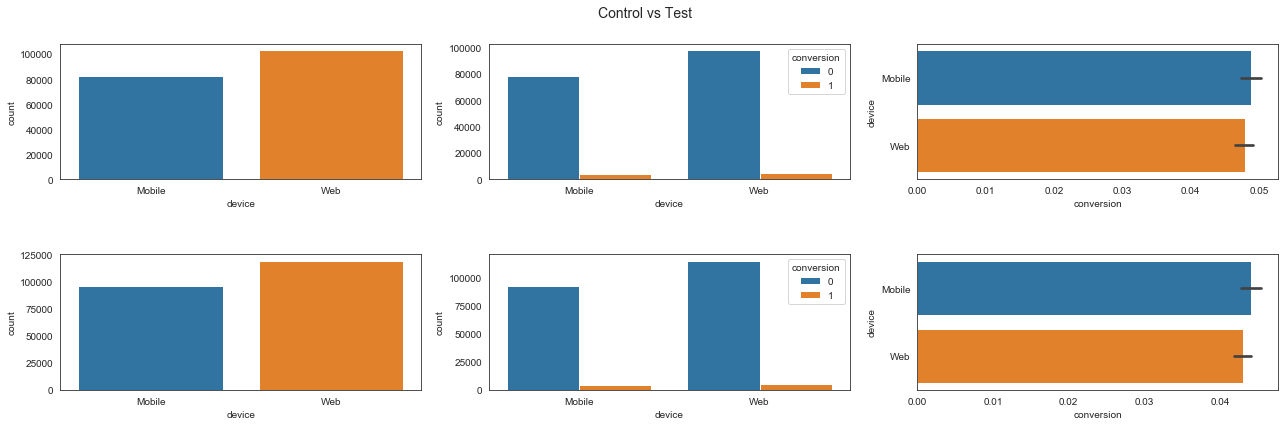

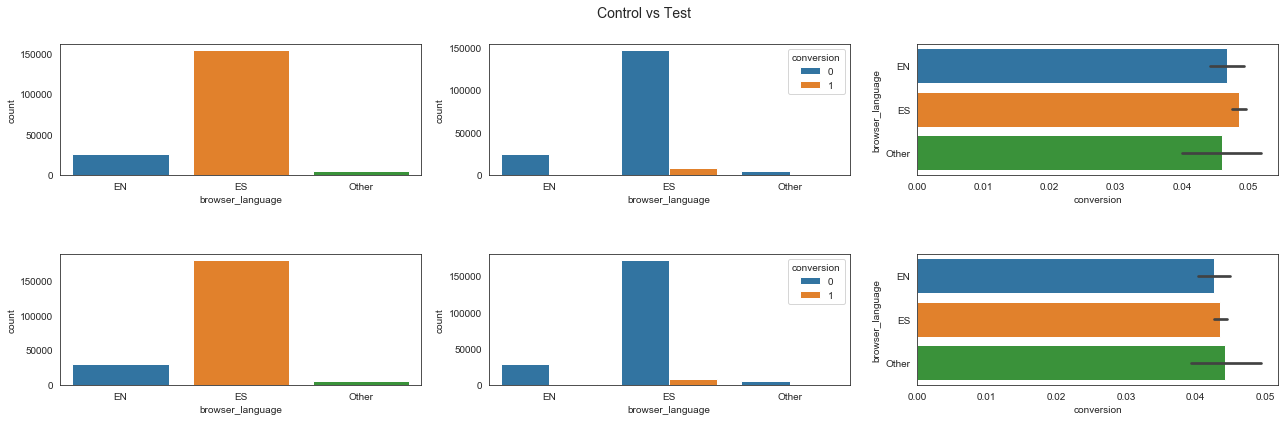

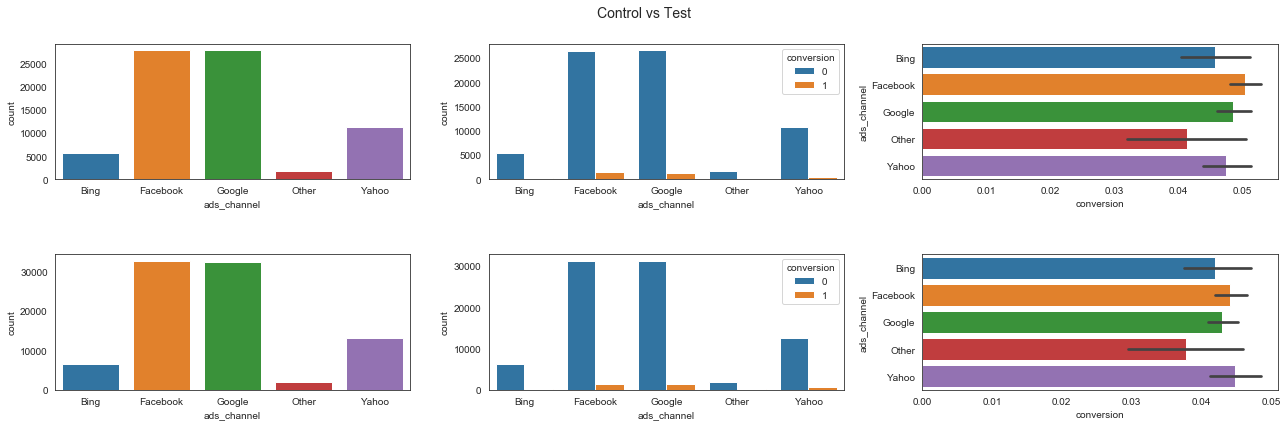

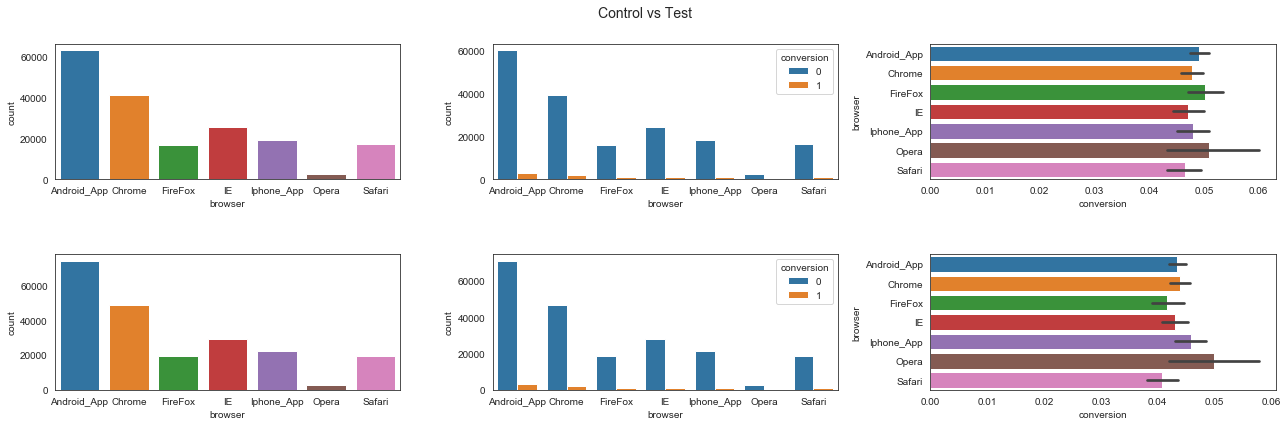

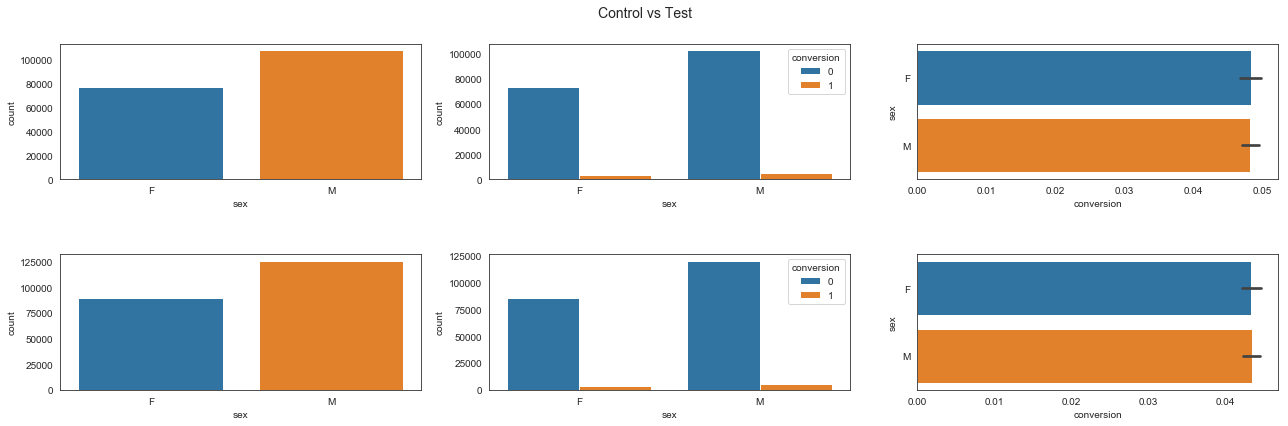

In [14]:
visualization(Cont,Test,2,3)

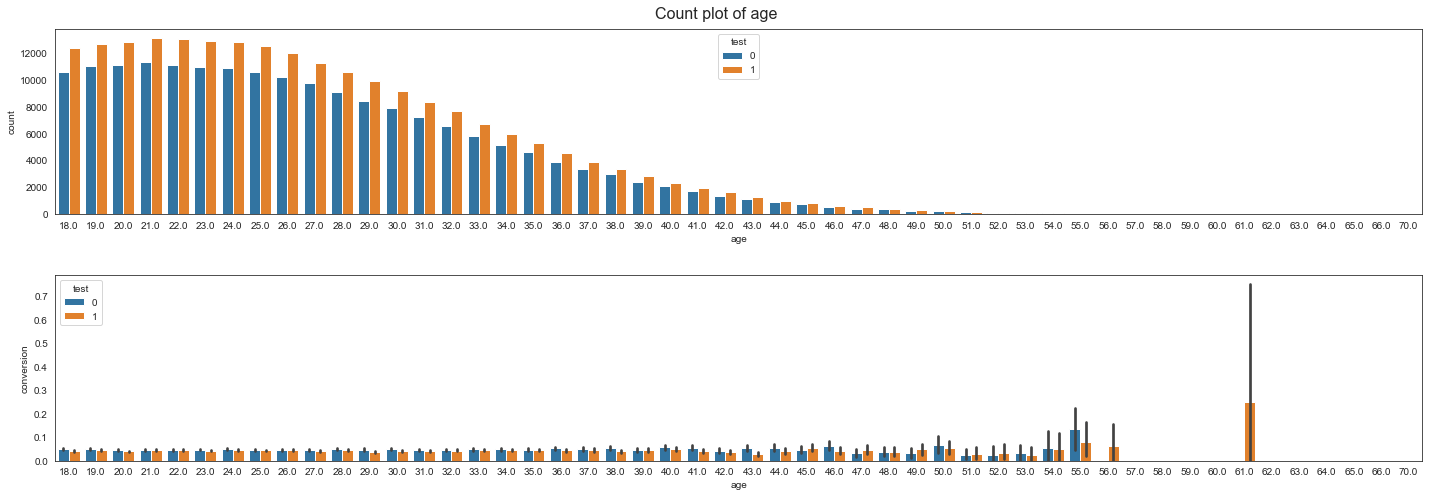

In [15]:
#  Age variable visualization
fig,ax=plt.subplots(2,1,figsize=(20,7))
sns.countplot(x='age',hue='test',data=data_goal,ax=ax[0])
sns.barplot(x=data_goal['age'],y=data_goal['conversion'],hue=data_goal['test'],ax=ax[1]);
fig.suptitle('Count plot of age',fontsize=16)
fig.subplots_adjust(top=0.25)
plt.tight_layout()

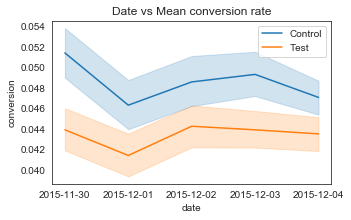

In [16]:
# Date variable visualization
plt.subplots(1,1,figsize=(5,3))
plt.title('Date vs Mean conversion rate')
sns.lineplot(x='date',y='conversion',data=Cont,err_style='band',label='Control')
sns.lineplot(x='date',y='conversion',data=Test,err_style='band',label='Test');
plt.legend();

I am evaluating each variable except for country based on control and test group, what I find is that:
1. For source, device, browser_language, ads_channel, browser, sex and age variables, there's no obvious differece between two groups and they both follow the same pattern.
2. When I plot all five test days out, it is clear that mean conversion rate for control group outperforms that for test group everyday. However, we can see there existed small fluctuations during five days and I think this is common because users also need time to adapt to change and five days include randomness. Consequently, test period of five days might probably detect nothing about true effect of changing translation. I think the sensible test time should be 2 weeks which can help teams identify the true pattern.

Next step I am planning to break down country variable and check mean conversion rate for each country on control and test group, respectively.

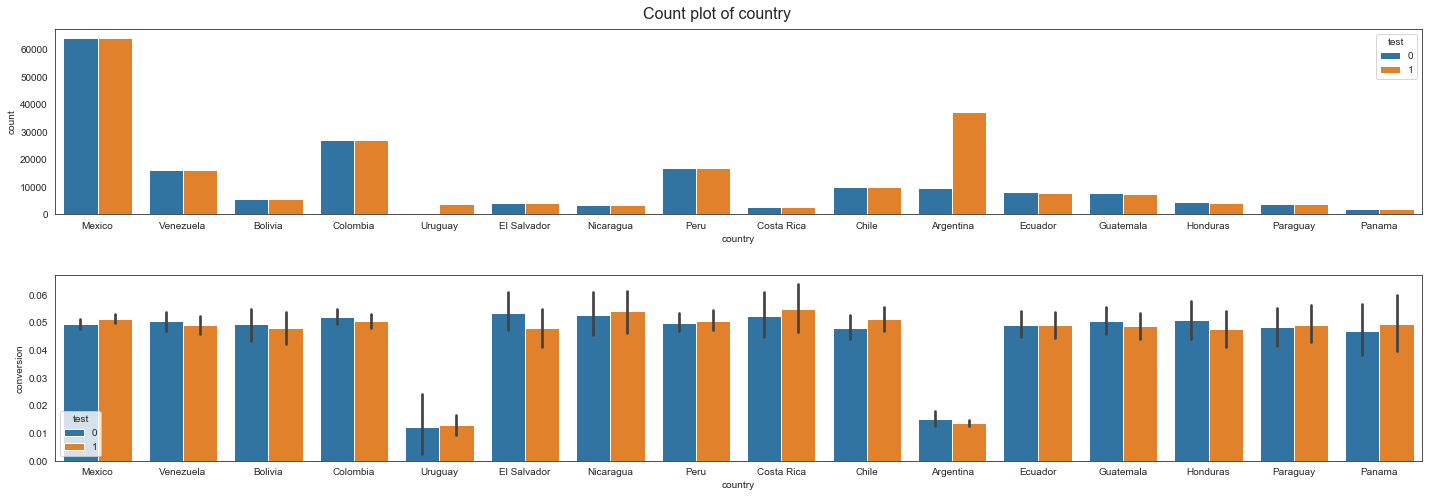

In [17]:
fig,ax=plt.subplots(2,1,figsize=(20,7))
sns.countplot(data_goal['country'],hue=data_goal['test'],ax=ax[0])
sns.barplot(x='country',y='conversion',hue='test',data=data_goal,ax=ax[1])
fig.suptitle('Count plot of country',fontsize=16)
fig.subplots_adjust(top=0.25)
plt.tight_layout()

From coutry variable plots, it is clear that there are two contries, Uruguay and Argentina, that their control and test group have different number of users, which is not acceptable due to other countries all keep the 50/50 pattern. I think what fraction of visitors you want to be in control or test group should keep consistent on each level. Further, although the overall conversion rate of control is over that of test, we find that it is not right for each Spanish speaking country, which indicates changing to localized translation might be essentially not bad. Thus, it is worth doing a t test here.

In [18]:
print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.format('Country', 'Mean of Control', 'Mean of Test', 'P-Value', 'No.Control/No.Test'))
print('-' * 85)
p=[]
for country in data_goal['country'].dropna().unique():
    data_country = data_goal[data_goal['country']==country]
    cont_country = data_country[data_country['test']==0].conversion.values
    test_country = data_country[data_country['test']==1].conversion.values
    p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
    p.append(p_value)
    ratio = len(cont_country)/len(test_country)
    print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

After we control for country, the test clearly appears non significant. Now we know that a localized translation does not result in conversion rate drop. 

### Q3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

The process we try to identify what was wrong tells us the main problem is about country variable. Our design for users in control or test group are not even on some countries, which might lead to noise for our experiment. Further, when calibrating the model on each country level, the result is not significant anymore. Thus, I tend to design an algorithm to sanity check problem about country, like if users are evenly divided into control and test groups, or if the result is significant on each country.


In [19]:
def sanitycheck(data,error):
    # no need to include users in Spain
    data = data[data['country']!='Spain']
    country_name = data['country'].dropna().unique()
    sig_country=[]
    print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.
          format('Country', 'Mean of Control','Mean of Test', 'P-Value', 'No.Control/No.Test'))
    print('-' * 85)
    # check each country
    for country in country_name:
        data_country = data[data['country']==country]
        # split into control and test group
        cont_country = data_country[data_country['test']==0].conversion.values
        test_country = data_country[data_country['test']==1].conversion.values
        p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
        if p_value < error:
            sig_country.append(country)
        ratio = len(cont_country)/len(test_country)
        print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.
              format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    if len(sig_country)==len(country_name):
        print('Everything is good and the result can be trusted!')
        return('TRUE')
    else:
        print('There is at least something wrong among one of countries, its result is not significant. Please check.' )
        return('FALSE')
    

In [20]:
sanitycheck(data_goal,0.05)

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

'FALSE'